In [1]:
%matplotlib inline
# import some dependencies
import numpy as np
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set()
except ImportError:
    pass

import torch
from torch.autograd import Variable

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

torch.manual_seed(101)

# Simple Example of Pyro Inference
## Weighing Scale example

In [2]:

def scale(guess):
    # The prior over weight encodes our uncertainty about our guess
    weight = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
    # This encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true weight
    return pyro.sample("measurement", dist.normal, weight, Variable(torch.Tensor([0.75])))

#### Marginalization in Pyro with pyro.infer.Marginal is split into two steps. First, we collect a number of weighted execution traces of the model. Then, we can collapse those traces into a histogram over possible return values given a particular set of arguments.

In [3]:
posterior = pyro.infer.Importance(scale, num_samples=100)

In [4]:
guess = Variable(torch.Tensor([8.5]))

marginal = pyro.infer.Marginal(posterior)
print(marginal(guess))

Variable containing:
 7.9588
[torch.FloatTensor of size 1]



Text(0,0.5,u'#')

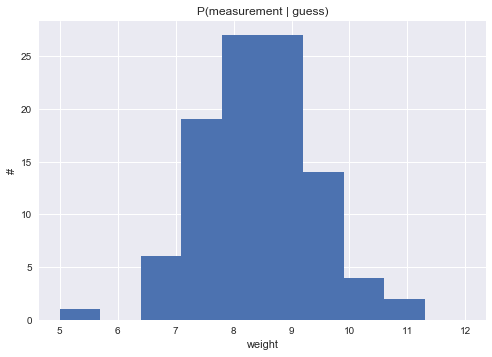

In [5]:
plt.hist([marginal(guess).data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#")

##### pyro.infer.Marginal also accepts the optional keyword argument sites=[name1, name2, ...] that provides a list of names of latent variables. When sites is specified, marginal will return a dictionary where the keys are the names in sites and the values are values at those sites from a single execution trace. This is useful because we may wish to compute many different marginals from the same posterior object. 
##### SELF NOTE: We get the latent variable values as well ! we can get the marginals of latent vars from the same posterior object !! 
##### SELF NOTE 2: A marginal (I think) is helpful for computational complexity/cost when computing larger marginals (built on more vars). A sort of hierarchy and separation (unsure, review later with more info)
# Conditioning Models on Data
### In this we condition/constrain a sample/set of sampling functions to match an observation, either before or after. Changes the data generation to work with the conditioned/OBSERVED variable.


In [6]:
conditioned_scale = pyro.condition(
    scale, data={"measurement": Variable(torch.Tensor([8.5]))})

In [7]:
def deferred_conditioned_scale(measurement, *args, **kwargs):
    return pyro.condition(scale, data={"measurement": measurement})(*args, **kwargs)

In [8]:
# equivalent to pyro.condition(scale, data={"measurement": Variable(torch.ones(1))})
def scale_obs(guess):
    z = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
     # here we attach an observation measurement == 1
    return pyro.sample("measurement", dist.normal, weight, Variable(torch.ones(1)),
                       obs=Variable(torch.Tensor([0.1])))

# equivalent to scale_obs:
def scale_obs(guess):
    z = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
    # here we attach an observation measurement == 1
    return pyro.observe("measurement", dist.normal, Variable(torch.ones(1)),
                        weight, Variable(torch.Tensor([0.1])))

#### IMPORTANT: The only restriction is that a single site may only be constrained once. Often it is better to condition it later as needed
### Composing /combining conditions

In [9]:
def scale2(guess):
    weight = pyro.sample("weight", dist.normal,
                         guess, Variable(torch.ones(1)))
    tolerance = torch.abs(
        pyro.sample("tolerance", dist.normal, Variable(torch.zeros(1)), Variable(torch.ones(1))))

    return pyro.sample("measurement", dist.normal, weight, tolerance)

# conditioning composes:
# the following are all equivalent and do not interfere with each other
conditioned_scale2_1 = pyro.condition(
    pyro.condition(scale2, data={"weight": Variable(torch.ones(1))}),
    data={"measurement": Variable(torch.ones(1))})

conditioned_scale2_2 = pyro.condition(
    pyro.condition(scale2, data={"measurement": Variable(torch.ones(1))}),
    data={"weight": Variable(torch.ones(1))})

conditioned_scale2_3 = pyro.condition(
    scale2, data={"weight": Variable(torch.ones(1)), "measurement": Variable(torch.ones(1))})

###### Apparently these is a Pyro.do operator that is like Pearl's do operator. Used for causal inference (given observations what laten vars could have caused it). Verbatim from tutorial "identical interface to pyro.condition. condition and do can be mixed and composed freely, making Pyro a powerful tool for model-based causal inference"


# FLEXIBLE APPROX INFERENCE w GUIDE FUNCTIONS

{'weight': Variable containing:
 8.3751
[torch.FloatTensor of size 1]
}


Text(0,0.5,u'#')

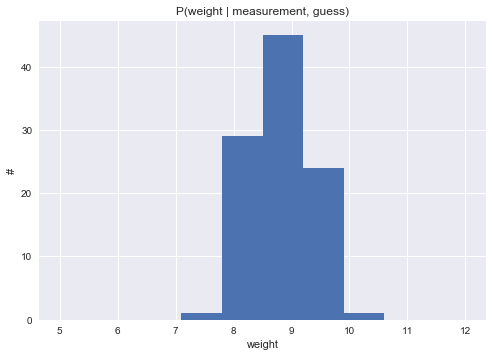

In [10]:

guess = Variable(torch.Tensor([8.5]))
measurement = Variable(torch.Tensor([9.5]))

conditioned_scale = pyro.condition(scale, data={"measurement": measurement})

marginal = pyro.infer.Marginal(
    pyro.infer.Importance(conditioned_scale, num_samples=100), sites=["weight"])

# The marginal distribution concentrates around the data
print(marginal(guess))
plt.hist([marginal(guess)["weight"].data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

# To be a valid guide function for a var
#### 1. all unobserved sample statements that appear in the model appear in the guide. 
These NOTES NEED REVIEW
EXAMPLE: The measurement that we have observed is x. The guide should have/handle other measurement values as well.
(Self note: So we expect the ones that we have sampled are the high probability ones, and for the other samples, we can be content with the guide/approximation probability. Saves on computational efficiency)
#### 2. the guide has the same input signature as the model (i.e. takes the same arguments)

### IMPORTANT The precise meaning of the guide is different across different inference algorithms.|
Guide function is chosen so that it closely approximates the distribution over all unobserved sample statements in the model. The simplest guide for deferred_conditioned_scale matches the prior distribution over weight:


In [11]:

def scale_prior_guide(guess):
    return pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))

posterior = pyro.infer.Importance(conditioned_scale,
                                  guide=scale_prior_guide,
                                  num_samples=10)

marginal = pyro.infer.Marginal(posterior, sites=["weight"])

Text(0,0.5,u'#')

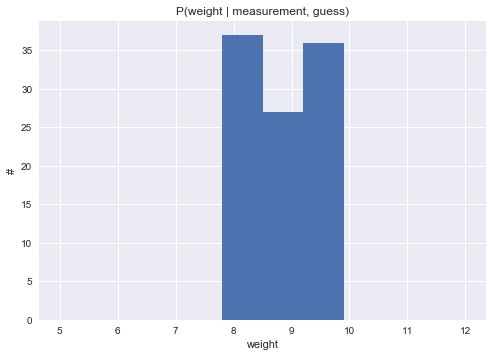

In [12]:
def scale_posterior_guide(measurement, guess):
    # note that torch.size(measurement, 0) is the total number of measurements
    # that we're conditioning on
    a = (guess + torch.sum(measurement)) / (measurement.size(0) + 1.0)
    b = Variable(torch.ones(1)) / (measurement.size(0) + 1.0)
    return pyro.sample("weight", dist.normal, a, b)

posterior = pyro.infer.Importance(deferred_conditioned_scale,
                                  guide=scale_posterior_guide,
                                  num_samples=20)

marginal = pyro.infer.Marginal(posterior, sites=["weight"])
plt.hist([marginal(measurement, guess)["weight"].data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

# Parametrized Stoch Funcs and Variational Inference
##### a family of guides indexed by named parameters, and search for the member of that family that is the best approximation. This approach to approximate posterior inference is called variational inference.

In [13]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", Variable(torch.randn(1) + guess.data.clone(), requires_grad=True))
    b = pyro.param("b", Variable(torch.randn(1), requires_grad=True))
    return pyro.sample("weight", dist.normal, a, torch.abs(b))
# IMPORTANT: The parameters are the ones that will get updated by optimization
# (eg: by SGD). When setting requires_grad = True, it signals that (unsure?)

### Pyro is built to enable stochastic variational inference, a powerful and widely applicable class of variational inference algorithms with three key characteristics: 
#####  1. Parameters are always real-valued tensors 
##### 2. We compute Monte Carlo estimates of a loss function from samples of execution histories of the model and guide 
##### 3. We use stochastic gradient descent to search for the optimal parameters.

Text(0,0.5,u'loss')

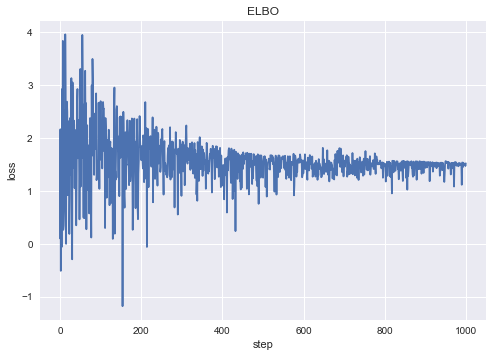

In [14]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model = conditioned_scale,
                    guide=scale_parametrized_guide,
                    optim = pyro.optim.SGD({"lr":0.001}),
                     loss = "ELBO")
losses = []
for t in range(1000):
    losses.append(svi.step(guess))

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
    

### IMPORTANT: Note that optimization will update the guide parameters, but does not produce a posterior distribution object itself. Once we find good parameter values, we can just use the guide as a representation of the model’s approximate posterior for downstream tasks.
###### In our running example, the guide for the weight , as an importance distribution for estimating the marginal WITH FEWER SAMPLES than before (see below). We would have otherwised used the prior, done importance sampling, and then infer the marginal. Typically, exact inference is not feasible for large networks. 
###### We can also DIRECTLY sample from the guide as an approx posterior.

Text(0,0.5,u'#')

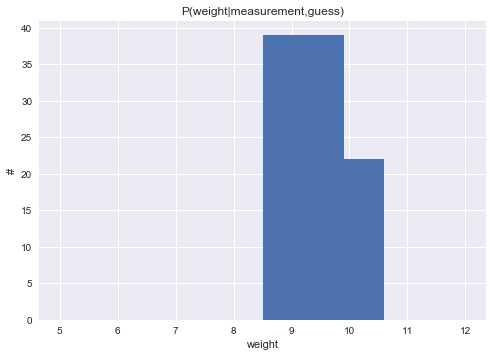

In [15]:
#recall conditioned scale was scale conditioned on measurement = 8.5
posterior = pyro.infer.Importance(conditioned_scale, 
                scale_parametrized_guide, num_samples = 10)
marginal = pyro.infer.Marginal(posterior, sites = ["weight"])
plt.hist([marginal(guess)["weight"].data[0] for _ in range(100)], 
        range = (5.0,12.0))
plt.title("P(weight|measurement,guess)")
plt.xlabel("weight")
plt.ylabel("#")




Text(0,0.5,u'#')

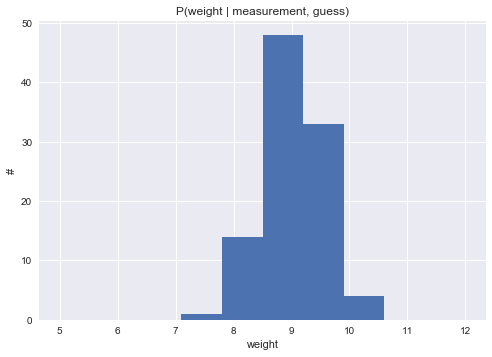

In [16]:
#IMPORTANT here is how we can sample directly from the guide
plt.hist([scale_parametrized_guide(guess).data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")


# Now move onto the SVI tutorial